# Projecto MLOPS

In [1]:
import pandas as pd 
import numpy as np
import os
from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv("./archive/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep = ',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Ahora vamos a mirar cuantos valores nulos tenemos para cada columna

In [10]:
df.isnull().sum()

# 2️⃣ Drop columns with more than 50% missing values
threshold = 0.5
missing_fraction = df.isnull().mean()
cols_to_drop = missing_fraction[missing_fraction > threshold].index
df = df.drop(columns=cols_to_drop)
print(f"Dropped columns: {list(cols_to_drop)}")

# 3️⃣ Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# 4️⃣ Impute numerical columns (mean or median)
num_imputer = SimpleImputer(strategy='median')  # or strategy='mean'
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# 5️⃣ Impute categorical columns (mode or placeholder)
cat_imputer = SimpleImputer(strategy='most_frequent')  # or fill with 'Unknown'
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# 6️⃣ Verify that missing values are handled
print("Missing values after imputation:")
print(df.isnull().sum())



Dropped columns: []
Missing values after imputation:
gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
S

In [11]:
# 1. Asegurar que columnas numéricas sean numéricas (float/int)
# 'TotalCharges' suele cargarse como objeto porque tiene espacios vacíos " "
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Llenar los nulos generados (espacios vacíos) con 0 o la media (opcional, pero recomendado)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 2. Asegurar que columnas categóricas sean objeto/string
# 'SeniorCitizen' viene como 0/1 (int), pero conceptualmente es categórica
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

# Verificar tipos de datos
print("Tipos de datos corregidos:")
print(df.dtypes)

# 3. Eliminar duplicados exactos (filas completas repetidas)
duplicados_totales = df.duplicated().sum()
print(f"\nFilas duplicadas eliminadas: {duplicados_totales}")
df.drop_duplicates(inplace=True)

# 4. Verificar duplicados en CustomerID
# Esto es crítico: un ID no debería tener dos filas distintas
ids_duplicados = df[df.duplicated(subset=['customerID'], keep=False)]

if not ids_duplicados.empty:
    print(f"\n¡Atención! Se encontraron {len(ids_duplicados)} entradas con customerID duplicado:")
    print(ids_duplicados[['customerID', 'Tenure', 'MonthlyCharges']].head())
else:
    print("\nNo existen customerID duplicados. La integridad es correcta.")

Tipos de datos corregidos:
gender                                   float64
SeniorCitizen                             object
Partner                                  float64
Dependents                               float64
tenure                                   float64
PhoneService                             float64
PaperlessBilling                         float64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                    float64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                      

KeyError: Index(['customerID'], dtype='object')

Now we can drop the customerID column which has no predictive value and would break our API

In [12]:
df  = df.drop('customerID', axis=1)

KeyError: "['customerID'] not found in axis"

In [5]:
binary_mapping = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map(binary_mapping)

# -----------------------------------------
# 6️⃣ One-Hot Encode multi-class categoricals
multi_class_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# -----------------------------------------
# Confirm final dataset
print(df.head())
print(df.info())


   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0            0.0        1           0     1.0   
1  5575-GNVDE       1            0.0        0           0    34.0   
2  3668-QPYBK       1            0.0        0           0     2.0   
3  7795-CFOCW       1            0.0        0           0    45.0   
4  9237-HQITU       0            0.0        0           0     2.0   

   PhoneService  PaperlessBilling  MonthlyCharges TotalCharges  ...  \
0             0                 1           29.85        29.85  ...   
1             1                 0           56.95       1889.5  ...   
2             1                 1           53.85       108.15  ...   
3             0                 0           42.30      1840.75  ...   
4             1                 1           70.70       151.65  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            F

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0.0,1,0,1.0,0,1,29.85,29.85,...,False,False,False,False,False,False,False,False,True,False
1,5575-GNVDE,1,0.0,0,0,34.0,1,0,56.95,1889.5,...,False,False,False,False,False,True,False,False,False,True
2,3668-QPYBK,1,0.0,0,0,2.0,1,1,53.85,108.15,...,False,False,False,False,False,False,False,False,False,True
3,7795-CFOCW,1,0.0,0,0,45.0,0,0,42.30,1840.75,...,True,False,False,False,False,True,False,False,False,False
4,9237-HQITU,0,0.0,0,0,2.0,1,1,70.70,151.65,...,False,False,False,False,False,False,False,False,True,False


We will use a StandardScaler for the 3 numerical columns

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# List of numeric columns to scale
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 1️⃣ StandardScaler (zero mean, unit variance)
std_scaler = StandardScaler()
df[numeric_cols] = std_scaler.fit_transform(df[numeric_cols])



Features exceeding 0.9 correlation to drop: ['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


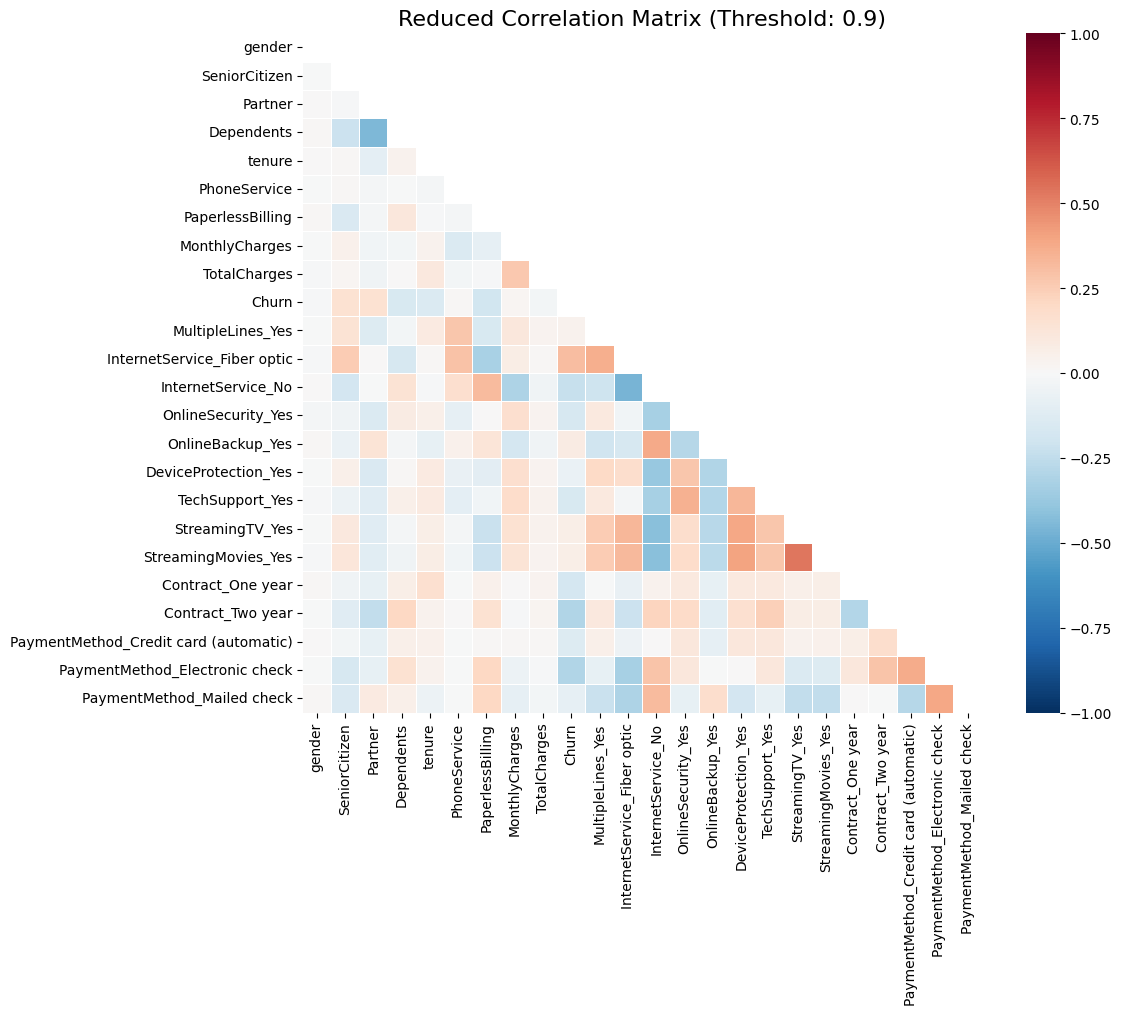

Original feature count: 31
Reduced feature count: 24


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your loaded dataframe
# 0. PRE-PROCESSING (Crucial step usually missed)
# ------------------------------------------------
# Ensure TotalCharges is numeric (it often loads as object due to empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Remove ID first
if 'customerID' in df.columns:
    df_sin_id = df.drop('customerID', axis=1)
else:
    df_sin_id = df.copy()

# ------------------------------------------------
# 1. ENCODING (The fix for "Sparse/Empty" Matrix)
# ------------------------------------------------
# We make a copy and factorize (Label Encode) ALL columns just for correlation analysis
# This turns "Yes"/"No" into 1/0, and "DSL"/"Fiber" into 0/1 so .corr() can read them.
df_encoded = df_sin_id.apply(lambda x: pd.factorize(x)[0])

# ------------------------------------------------
# 2. IDENTIFY & DROP REDUNDANT FEATURES
# ------------------------------------------------
# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Define threshold (0.9 is a good standard)
threshold = 0.90

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(f"Features exceeding {threshold} correlation to drop: {to_drop}")

# Drop them from our encoded dataframe (and your real one later)
df_reduced_encoded = df_encoded.drop(columns=to_drop)

# ------------------------------------------------
# 3. PLOT THE FINAL "REDUCED" MATRIX
# ------------------------------------------------
plt.figure(figsize=(12, 10))

# Create a mask to hide the upper triangle (makes it easier to read)
mask = np.triu(np.ones_like(df_reduced_encoded.corr(), dtype=bool))

sns.heatmap(df_reduced_encoded.corr(), 
            mask=mask, 
            cmap='RdBu_r',  # Red/Blue is standard for correlations
            vmax=1, 
            vmin=-1, 
            center=0,
            square=True, 
            linewidths=.5, 
            annot=False) # Turn off annot if too messy, or set True if manageable

plt.title(f"Reduced Correlation Matrix (Threshold: {threshold})", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Original feature count: {df_sin_id.shape[1]}")
print(f"Reduced feature count: {df_reduced_encoded.shape[1]}")

In [15]:
print(df.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


More analysis plots

/tmp/ipykernel_389599/4205752769.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


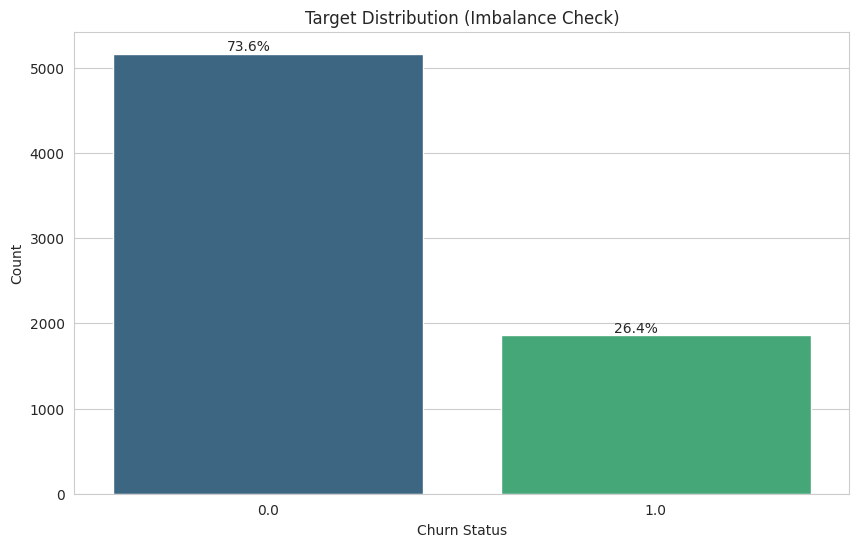

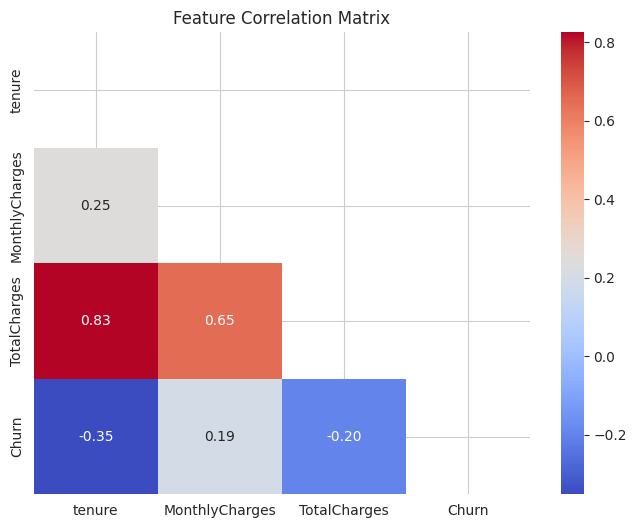

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


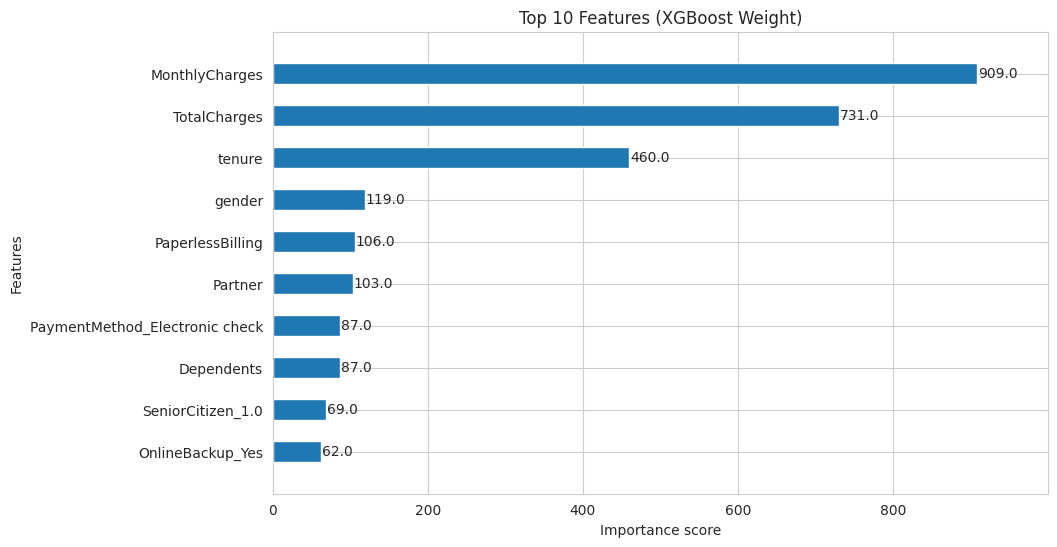

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================
# GRAPH 1: The Justification for Metrics (Class Balance)
# ==========================================
plt.figure()
ax = sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Target Distribution (Imbalance Check)')
plt.xlabel('Churn Status')
plt.ylabel('Count')

# Add percentage labels (Crucial for the report!)
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show() 
# REPORT CAPTION: "Figure 1: Class imbalance (26% vs 74%) justifies the use of PR-AUC over Accuracy."



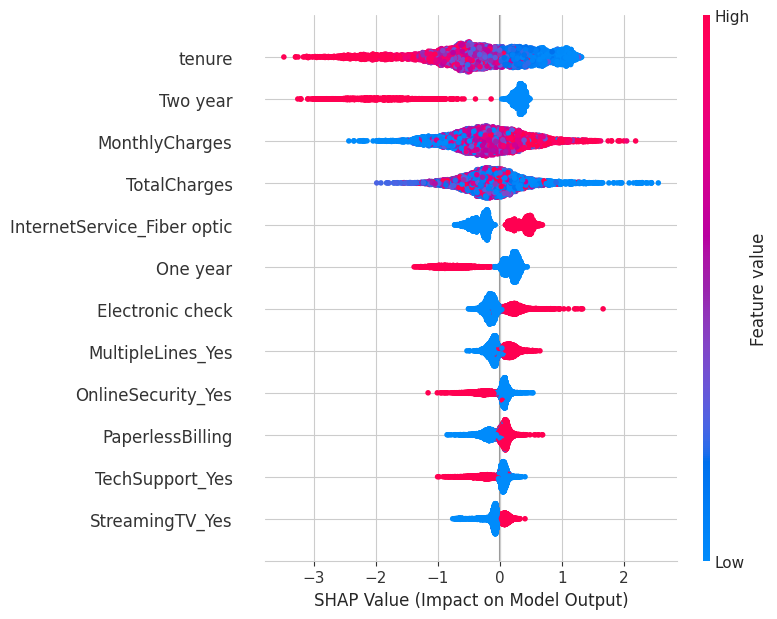

In [ ]:
import shap
import matplotlib.pyplot as plt

X = df_encoded
y = df['Churn_Bin']

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# 1. Compute SHAP values (as you likely already did)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 2. SETUP: Create the figure explicitly to control size
# Increasing the width (12) gives the text more room to breathe
f = plt.figure(figsize=(12, 6))

# 3. PLOT: The "Beeswarm" (Dot) plot
# max_display=12: Only shows top 12 features (cleaner)
# show=False: Allows us to modify the plot after generating it
shap.summary_plot(shap_values, X, 
                  max_display=12, 
                  show=False,
                  plot_type="dot") # "dot" is the default, but being explicit helps

# 4. CUSTOMIZATION: Fix the labels
# Get the current axes
ax = plt.gca()

# Optional: Clean up labels programmatically (remove 'PaymentMethod_', etc.)
# This iterates through the y-labels and replaces the prefix with nothing
new_labels = [label.get_text().replace("PaymentMethod_", "").replace("Contract_", "") 
              for label in ax.get_yticklabels()]
ax.set_yticklabels(new_labels)

# Increase label font size for readability in the report
ax.tick_params(axis='y', labelsize=12)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)

# 5. SAVE: The critical step for "wide" text
# bbox_inches='tight' fits the image exactly to the text, ensuring nothing is cut off
plt.tight_layout()
plt.savefig("shap_summary_clean.png", dpi=300, bbox_inches='tight')
plt.show()